# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [22]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
!pip install fetch-my-weather
!pip install hands-on-ai
!pip install pyinputplus

In [23]:
# import os

# os.environ['HANDS_ON_AI_SERVER'] = 'http://ollama.serveur.au'
# os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'
# os.environ['HANDS_ON_AI_API_KEY'] = input('Enter your API key: ')

## 📦 Setup and Configuration
Import required packages and setup environment.

In [24]:
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
# ✅ Import after installing (if needed)
from fetch_my_weather import get_weather
from hands_on_ai.chat import get_response


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np
# Add any other setup code here

## 🌤️ Weather Data Functions

In [25]:
import fetch_my_weather
def get_weather_data(location, forecast_days=5):
    """
    Retrieve weather data for a specified location.

    Args:
        location (str): City or location name
        forecast_days (int): Number of days to forecast (1-5)

    Returns:
        dict: Weather data including current conditions and forecast
    """


    # Input validation
    if not location or not isinstance(location, str):
        print("Error: location must be a non-empty string")
        return None

    if not 1 <= forecast_days <= 5:
        print("Error: forecast_days must be between 1 and 5")
        forecast_days = min(max(1, forecast_days), 5)  # Clamp to valid range

    try:
        # Fetch weather data using fetch-my-weather
        # Returns a JSON-formatted Pydantic model by default
        weather_response = fetch_my_weather.get_weather(
            location=location,
            format="json"
        )

        # Check if valid data was retrieved
        if weather_response is None:
            print(f"Unable to fetch weather data for {location}")
            return None

        # Check for error response
        if isinstance(weather_response, str) and weather_response.startswith("Error:"):
            print(f"Error fetching weather data: {weather_response}")
            return None

        # Process response
        result = {
            "location": location,
            "current": {},
            "forecast": []
        }

        # Extract current weather information
        if hasattr(weather_response, 'current_condition') and weather_response.current_condition:
            current = weather_response.current_condition[0]
            result["current"] = {
                "temperature": {
                    "current": current.temp_C,
                    "feels_like": current.FeelsLikeC
                },
                "condition": current.weatherDesc[0].value if current.weatherDesc else "Unknown",
                "humidity": current.humidity,
                "wind": {
                    "speed": current.windspeedKmph,
                    "direction": current.winddir16Point
                },
                "precipitation": current.precipMM
            }

        # Extract forecast information
        if hasattr(weather_response, 'weather') and weather_response.weather:
            for i in range(min(forecast_days, len(weather_response.weather))):
                day = weather_response.weather[i]
                # Use midday data as representative for the day
                midday_hour = min(4, len(day.hourly) - 1)  # Choose 4th hour (midday) or last available
                hourly_data = day.hourly[midday_hour]

                forecast_day = {
                    "date": day.date,
                    "max_temp": day.maxtempC,
                    "min_temp": day.mintempC,
                    "condition": hourly_data.weatherDesc[0].value if hourly_data.weatherDesc else "Unknown",
                    "precipitation": {
                        "chance": hourly_data.chanceofrain,
                        "amount": hourly_data.precipMM
                    },
                    "wind": {
                        "speed": hourly_data.windspeedKmph,
                        "direction": hourly_data.winddir16Point
                    }
                }
                result["forecast"].append(forecast_day)

        return result

    except Exception as e:
        print(f"An exception occurred while fetching weather data: {e}")
        return None


## 📊 Visualisation Functions

In [26]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def create_temperature_visualisation(weather_data, output_type='display'):
    if not weather_data or 'forecast' not in weather_data:
        print("Error: Invalid weather data")
        return None
    if not weather_data['forecast']:
        print("Error: No forecast data available")
        return None

    dates, max_temps, min_temps = [], [], []
    for day_data in weather_data['forecast']:
        try:
            date_str = day_data.get('date', '')
            if not date_str:
                continue
            date_obj = datetime.strptime(date_str, '%Y-%m-%d').date()

            max_temp_str = day_data.get('max_temp')
            min_temp_str = day_data.get('min_temp')
            if max_temp_str is None or min_temp_str is None:
                continue

            max_temp = float(max_temp_str)
            min_temp = float(min_temp_str)

            dates.append(date_obj)
            max_temps.append(max_temp)
            min_temps.append(min_temp)
        except (ValueError, TypeError):
            continue

    if not dates:
        print("Error: No valid temperature data found")
        return None

    # current
    current_temp = None
    if 'current' in weather_data and weather_data['current']:
        current_temp_str = weather_data['current'].get('temperature', {}).get('current')
        try:
            if current_temp_str is not None:
                current_temp = float(current_temp_str)
        except (ValueError, TypeError):
            print("Warning: Could not parse current temperature")

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(dates, max_temps, 'r-o', linewidth=2, markersize=6, label='Max Temperature', alpha=0.8)
    ax.plot(dates, min_temps, 'b-o', linewidth=2, markersize=6, label='Min Temperature', alpha=0.8)
    if len(dates) >= 1:
        ax.fill_between(dates, min_temps, max_temps, alpha=0.3, color='gray')

    if current_temp is not None:
        ax.axhline(y=current_temp, color='orange', linestyle='--', linewidth=2,
                   label=f'Current Temperature ({current_temp}°C)')

    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Temperature (°C)', fontsize=12)
    ax.set_title(f'Temperature Trend for {weather_data.get("location", "Unknown Location")}',
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.xticks(rotation=45)
    plt.tight_layout()

    if output_type == 'figure':
        return fig
    else:
        plt.show()
        return None


In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def create_precipitation_visualisation(weather_data, output_type='display'):
    """
    Create a bar chart visualization of precipitation forecast data.

    Args:
        weather_data (dict): The processed weather data dictionary
        output_type (str): Either 'display' to show the plot
                           or 'figure' to return the matplotlib figure object

    Returns:
        matplotlib.figure.Figure if output_type == 'figure'
        Otherwise, displays the chart and returns None
    """

    # ---- Validate input ----
    if not weather_data or 'forecast' not in weather_data:
        print("Error: Invalid weather data")
        return None
    if not weather_data['forecast']:
        print("Error: No forecast data available")
        return None

    # ---- Extract forecast precipitation (skip current here) ----
    dates, precip_amounts, precip_chances = [], [], []
    for day in weather_data['forecast']:
        try:
            date_str = day.get('date')
            if not date_str:
                continue
            date_obj = datetime.strptime(date_str, '%Y-%m-%d').date()

            precip = day.get('precipitation', {}) or {}
            amount_str, chance_str = precip.get('amount'), precip.get('chance')
            if amount_str is None or chance_str is None:
                continue

            amount = float(amount_str)
            chance = float(chance_str)

            dates.append(date_obj)
            precip_amounts.append(amount)
            precip_chances.append(chance)
        except (ValueError, TypeError):
            continue

    if not dates:
        print("Error: No valid precipitation data found")
        return None

    # ---- Current precipitation as a reference line (not a bar) ----
    current_precipitation = None
    cur_str = (weather_data.get('current') or {}).get('precipitation')
    try:
        if cur_str is not None:
            current_precipitation = float(cur_str)
    except (ValueError, TypeError):
        pass

    # ---- Check if all forecast precipitation values are zero ----
    all_zero = all(a == 0 for a in precip_amounts)

    # ---- Plot ----
    fig, ax = plt.subplots(figsize=(12, 6))

    if all_zero:
        # Show empty bars and an informative message
        ax.bar(dates, precip_amounts, edgecolor='navy', linewidth=1, alpha=0.7)
        ax.text(0.5, 0.65, 'No Precipitation Expected',
                transform=ax.transAxes, fontsize=16, fontweight='bold',
                ha='center', va='center', color='darkblue')
        ax.text(0.5, 0.56, 'All forecast days show 0% chance of rain',
                transform=ax.transAxes, fontsize=12, ha='center', va='center', color='gray')
        ax.set_ylim(-0.5, 2)
    else:
        # Normal precipitation visualization
        bars = ax.bar(dates, precip_amounts, edgecolor='navy', linewidth=1, alpha=0.7)

        # Add labels above each bar: "amount mm | chance %"
        for bar, amt, ch in zip(bars, precip_amounts, precip_chances):
            if amt > 0 or ch > 0:
                ax.text(bar.get_x() + bar.get_width() / 2.0,
                        bar.get_height() + 0.1,
                        f'{amt:.1f}mm | {ch:.0f}%',
                        ha='center', va='bottom', fontsize=9)

    # ---- Add current precipitation line (if available) ----
    if current_precipitation is not None:
        ax.axhline(y=current_precipitation, linestyle='--', linewidth=2,
                   label=f'Current precipitation: {current_precipitation:.1f}mm')

    # ---- Chart styling ----
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Precipitation Amount (mm)', fontsize=12)
    ax.set_title(f'Precipitation Forecast for {weather_data.get("location", "Unknown Location")}',
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Format x-axis with dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.xticks(rotation=45)

    # Show legend only if the current precipitation line is drawn
    if current_precipitation is not None:
        ax.legend(loc='best')

    plt.tight_layout()

    # ---- Return or display ----
    if output_type == 'figure':
        return fig
    else:
        plt.show()
        return None


## 🤖 Natural Language Processing

In [28]:
import re
def parse_weather_question(question):
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question

    Returns:
        dict: Extracted information including location, time period, and weather attribute
    """


    # Initialize result dictionary
    result = {
        'location': None,
        'time_period': None,
        'weather_attribute': None,
        'question_type': None,
        'original_question': question
    }

    # Convert to lowercase for easier matching
    question_lower = question.lower().strip()

    # Common location patterns
    location_patterns = [
        r'\bin\s+([A-Za-z\s]+?)(?:\s|$|,|\?|\.)',  # "in Sydney", "in New York"
        r'\bat\s+([A-Za-z\s]+?)(?:\s|$|,|\?|\.)',   # "at London", "at Paris"
        r'\bfor\s+([A-Za-z\s]+?)(?:\s|$|,|\?|\.)',  # "for Tokyo", "for Melbourne"
        r'\b([A-Za-z\s]+?)\s+weather',              # "Sydney weather", "London weather"
    ]

    # Extract location
    for pattern in location_patterns:
        match = re.search(pattern, question_lower)
        if match:
            location = match.group(1).strip()
            # Clean up common words that might be captured
            location = re.sub(r'\b(the|a|an|my|this|that)\b', '', location).strip()
            if location and len(location) > 1:  # Avoid single letters
                result['location'] = location.title()
                break

    # Time period patterns
    time_patterns = {
        'today': r'\b(today|this\s+day)\b',
        'tomorrow': r'\b(tomorrow|next\s+day)\b',
        'yesterday': r'\b(yesterday|previous\s+day)\b',
        'this_week': r'\b(this\s+week|week)\b',
        'this_weekend': r'\b(this\s+weekend|weekend)\b',
        'next_week': r'\b(next\s+week)\b',
        'now': r'\b(now|currently|right\s+now|at\s+the\s+moment)\b',
        'tonight': r'\b(tonight|this\s+evening)\b',
        'morning': r'\b(morning|this\s+morning)\b',
        'afternoon': r'\b(afternoon|this\s+afternoon)\b',
        'evening': r'\b(evening|this\s+evening)\b'
    }

    # Extract time period
    for time_key, pattern in time_patterns.items():
        if re.search(pattern, question_lower):
            result['time_period'] = time_key
            break

    # Weather attribute patterns
    weather_attributes = {
        'temperature': r'\b(temperature|temp|hot|cold|warm|cool|degrees?|°[cf]?)\b',
        'precipitation': r'\b(rain|rainy|precipitation|drizzle|shower|storm|thunderstorm|snow|snowy)\b',
        'humidity': r'\b(humidity|humid|moist|dry)\b',
        'wind': r'\b(wind|windy|breeze|gust|blowing)\b',
        'condition': r'\b(weather|condition|sunny|cloudy|overcast|clear|foggy|misty)\b',
        'pressure': r'\b(pressure|barometric|atmospheric)\b',
        'visibility': r'\b(visibility|visible|clear|fog|mist)\b',
        'uv_index': r'\b(uv|ultraviolet|sunburn|sun\s+index)\b'
    }

    # Extract weather attribute
    for attr_key, pattern in weather_attributes.items():
        if re.search(pattern, question_lower):
            result['weather_attribute'] = attr_key
            break

    # Question type patterns
    question_types = {
        'what': r'\b(what|what\'s|whats)\b',
        'how': r'\b(how|how\'s|hows)\b',
        'will': r'\b(will|will\s+it|will\s+there)\b',
        'is': r'\b(is|is\s+it|are\s+there)\b',
        'should': r'\b(should|should\s+i|should\s+we)\b',
        'can': r'\b(can|can\s+i|can\s+we)\b',
        'when': r'\b(when|when\s+will|when\s+is)\b',
        'where': r'\b(where|where\s+is|where\s+will)\b'
    }

    # Extract question type
    for qtype_key, pattern in question_types.items():
        if re.search(pattern, question_lower):
            result['question_type'] = qtype_key
            break

    # Special handling for common question patterns
    if 'will it rain' in question_lower or 'is it going to rain' in question_lower:
        result['weather_attribute'] = 'precipitation'
        result['question_type'] = 'will'
    elif 'how hot' in question_lower or 'how cold' in question_lower:
        result['weather_attribute'] = 'temperature'
        result['question_type'] = 'how'
    elif 'what\'s the weather' in question_lower or 'what is the weather' in question_lower:
        result['weather_attribute'] = 'condition'
        result['question_type'] = 'what'

    # Default values if nothing detected
    if not result['time_period']:
        result['time_period'] = 'now'  # Default to current weather
    if not result['weather_attribute']:
        result['weather_attribute'] = 'condition'  # Default to general weather condition
    if not result['question_type']:
        result['question_type'] = 'what'  # Default question type

    return result

## 🧩 Main Application Logic

In [29]:
def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """
    # Check if we have valid data
    if not weather_data or not parsed_question:
        return "I'm sorry, I don't have the weather information needed to answer your question."

    # Extract parsed information
    location = parsed_question.get('location', 'the requested location')
    time_period = parsed_question.get('time_period', 'now')
    weather_attribute = parsed_question.get('weather_attribute', 'condition')
    question_type = parsed_question.get('question_type', 'what')

    # Handle different question types and weather attributes
    if question_type == 'will' and weather_attribute == 'precipitation':
        # Handle "Will it rain?" questions
        if time_period == 'tomorrow' and weather_data.get('forecast'):
            if len(weather_data['forecast']) > 0:
                tomorrow_data = weather_data['forecast'][0]
                chance = float(tomorrow_data.get('precipitation', {}).get('chance', 0))
                if chance == 0:
                    return f"No, it will not rain tomorrow in {location}."
                elif chance < 30:
                    return f"It's unlikely to rain tomorrow in {location}. There's only a {chance}% chance."
                else:
                    return f"Yes, there's a {chance}% chance of rain tomorrow in {location}."

    elif question_type == 'what' and weather_attribute == 'temperature':
        # Handle "What's the temperature?" questions
        if time_period == 'now' and weather_data.get('current'):
            current_temp = weather_data['current'].get('temperature', {}).get('current')
            if current_temp:
                return f"The current temperature in {location} is {current_temp}°C."
        elif time_period == 'today' and weather_data.get('forecast'):
            if len(weather_data['forecast']) > 0:
                today_data = weather_data['forecast'][0]
                max_temp = today_data.get('max_temp')
                min_temp = today_data.get('min_temp')
                if max_temp and min_temp:
                    return f"Today's temperature in {location} will range from {min_temp}°C to {max_temp}°C."

    elif question_type == 'how' and weather_attribute == 'temperature':
        # Handle "How hot/cold is it?" questions
        if time_period == 'now' and weather_data.get('current'):
            current_temp = float(weather_data['current'].get('temperature', {}).get('current', 0))
            if current_temp > 25:
                return f"It's quite warm in {location} right now at {current_temp}°C."
            elif current_temp > 15:
                return f"It's mild in {location} right now at {current_temp}°C."
            else:
                return f"It's cool in {location} right now at {current_temp}°C."

    elif question_type == 'should' and weather_attribute == 'precipitation':
        # Handle "Should I bring an umbrella?" questions
        if time_period == 'tomorrow' and weather_data.get('forecast'):
            if len(weather_data['forecast']) > 0:
                tomorrow_data = weather_data['forecast'][0]
                chance = float(tomorrow_data.get('precipitation', {}).get('chance', 0))
                if chance > 50:
                    return f"Yes, you should bring an umbrella to {location} tomorrow. There's a {chance}% chance of rain."
                else:
                    return f"No need for an umbrella in {location} tomorrow. There's only a {chance}% chance of rain."

    # Default response for general weather questions
    if weather_data.get('current'):
        current_temp = weather_data['current'].get('temperature', {}).get('current')
        condition = weather_data['current'].get('condition')

        response = f"Here's the current weather information for {location}: "
        if current_temp:
            response += f"Temperature is {current_temp}°C"
        if condition:
            response += f", and the condition is {condition}"
        response += "."

        return response

    return f"I can provide weather information for {location}, but I need more specific details about what you're asking."

## 🧪 Testing and Examples

### Testing get_weather_data

In [30]:
# Include sample input/output for each function
weather_data = get_weather_data("Tokyo", 5)
weather_data

{'location': 'Tokyo',
 'current': {'temperature': {'current': '27', 'feels_like': '31'},
  'condition': 'Patchy rain nearby',
  'humidity': '88',
  'wind': {'speed': '31', 'direction': 'SW'},
  'precipitation': '0.0'},
 'forecast': [{'date': '2025-09-20',
   'max_temp': '26',
   'min_temp': '25',
   'condition': 'Patchy rain nearby',
   'precipitation': {'chance': '100', 'amount': '0.1'},
   'wind': {'speed': '19', 'direction': 'ESE'}},
  {'date': '2025-09-21',
   'max_temp': '27',
   'min_temp': '25',
   'condition': 'Sunny',
   'precipitation': {'chance': '0', 'amount': '0.0'},
   'wind': {'speed': '37', 'direction': 'WSW'}},
  {'date': '2025-09-22',
   'max_temp': '24',
   'min_temp': '23',
   'condition': 'Partly Cloudy ',
   'precipitation': {'chance': '0', 'amount': '0.0'},
   'wind': {'speed': '40', 'direction': 'NE'}}]}


### Testing_create_temperature_visualisation

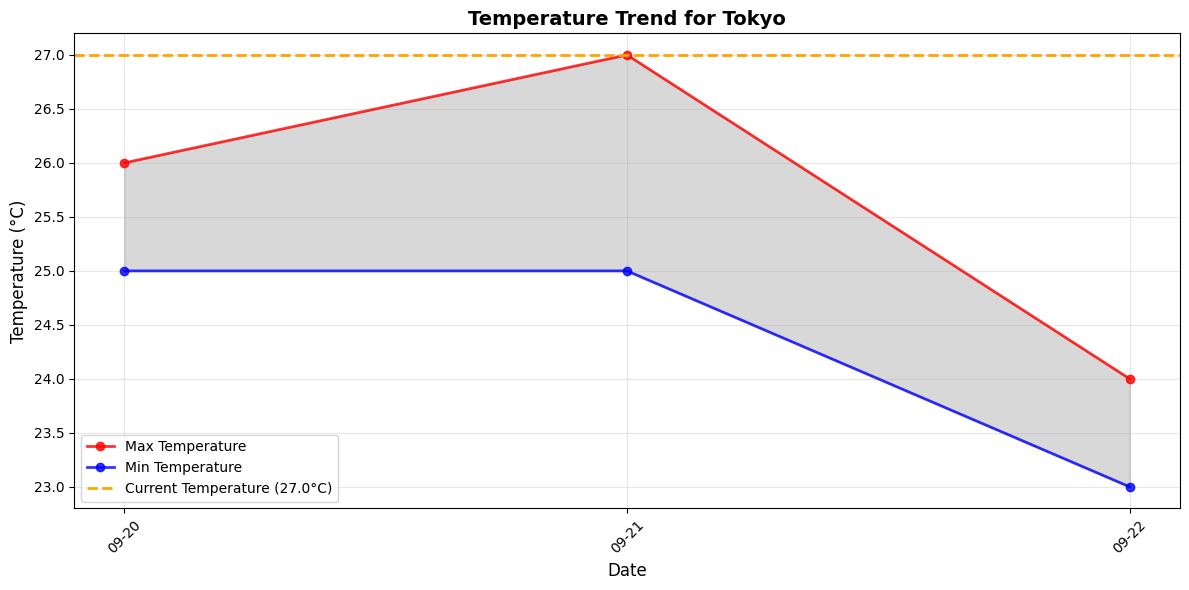

In [31]:
create_temperature_visualisation(weather_data,output_type='display')

### Testing_create_precipitation_visualisation

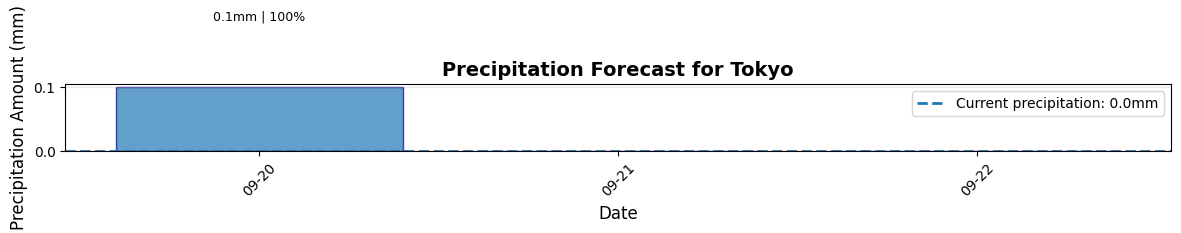

In [32]:
create_precipitation_visualisation(weather_data=weather_data)

### Testing_parse_weather_question

In [33]:
# Test examples for parse_weather_question function

# Example 1: Basic temperature question
question1 = "What's the temperature in Sydney today?"
result1 = parse_weather_question(question1)
print("Example 1:")
print(f"Question: {question1}")
print(f"Result: {result1}")
print()

# Example 2: Precipitation question
question2 = "Will it rain tomorrow in London?"
result2 = parse_weather_question(question2)
print("Example 2:")
print(f"Question: {question2}")
print(f"Result: {result2}")
print()

# Example 3: General weather condition
question3 = "How's the weather in Tokyo this weekend?"
result3 = parse_weather_question(question3)
print("Example 3:")
print(f"Question: {question3}")
print(f"Result: {result3}")
print()

# Example 4: Wind question
question4 = "Is it windy in Paris right now?"
result4 = parse_weather_question(question4)
print("Example 4:")
print(f"Question: {question4}")
print(f"Result: {result4}")
print()

# Example 5: Humidity question
question5 = "What's the humidity like in Melbourne this morning?"
result5 = parse_weather_question(question5)
print("Example 5:")
print(f"Question: {question5}")
print(f"Result: {result5}")
print()

# Example 6: Complex question
question6 = "Should I bring an umbrella to New York tomorrow?"
result6 = parse_weather_question(question6)
print("Example 6:")
print(f"Question: {question6}")
print(f"Result: {result6}")
print()

# Example 7: Question without location
question7 = "What's the weather like today?"
result7 = parse_weather_question(question7)
print("Example 7:")
print(f"Question: {question7}")
print(f"Result: {result7}")
print()

# Example 8: Question with multiple weather attributes
question8 = "How hot and humid will it be in Bangkok this week?"
result8 = parse_weather_question(question8)
print("Example 8:")
print(f"Question: {question8}")
print(f"Result: {result8}")
print()

Example 1:
Question: What's the temperature in Sydney today?
Result: {'location': 'Sydney', 'time_period': 'today', 'weather_attribute': 'temperature', 'question_type': 'what', 'original_question': "What's the temperature in Sydney today?"}

Example 2:
Question: Will it rain tomorrow in London?
Result: {'location': 'London', 'time_period': 'tomorrow', 'weather_attribute': 'precipitation', 'question_type': 'will', 'original_question': 'Will it rain tomorrow in London?'}

Example 3:
Question: How's the weather in Tokyo this weekend?
Result: {'location': 'Tokyo', 'time_period': 'this_weekend', 'weather_attribute': 'condition', 'question_type': 'how', 'original_question': "How's the weather in Tokyo this weekend?"}

Example 4:
Question: Is it windy in Paris right now?
Result: {'location': 'Paris', 'time_period': 'now', 'weather_attribute': 'wind', 'question_type': 'is', 'original_question': 'Is it windy in Paris right now?'}

Example 5:
Question: What's the humidity like in Melbourne this 

### Testing_generate_weather_response

In [34]:
# Test examples for the complete weather system

# Example 1: Test temperature question
print("="*60)
print("EXAMPLE 1: Temperature Question")
print("="*60)

# TODO: get data from get_weather_data
# Sample weather data (using the format from your earlier example)
weather_data_sydney = {
    'location': 'Sydney',
    'current': {
        'temperature': {'current': '20', 'feels_like': '20'},
        'condition': 'Sunny',
        'humidity': '49',
        'wind': {'speed': '22', 'direction': 'WSW'},
        'precipitation': '0.0'
    },
    'forecast': [
        {'date': '2025-09-20', 'max_temp': '21', 'min_temp': '13', 'condition': 'Sunny',
         'precipitation': {'chance': '0', 'amount': '0.0'}, 'wind': {'speed': '31', 'direction': 'WSW'}},
        {'date': '2025-09-21', 'max_temp': '21', 'min_temp': '10', 'condition': 'Sunny',
         'precipitation': {'chance': '0', 'amount': '0.0'}, 'wind': {'speed': '11', 'direction': 'W'}},
        {'date': '2025-09-22', 'max_temp': '21', 'min_temp': '11', 'condition': 'Sunny',
         'precipitation': {'chance': '0', 'amount': '0.0'}, 'wind': {'speed': '6', 'direction': 'WNW'}}
    ]
}

# Test question 1
question1 = "What's the temperature in Sydney today?"
print(f"Question: {question1}")

# Parse the question
parsed1 = parse_weather_question(question1)
print(f"Parsed: {parsed1}")

# Generate response
response1 = generate_weather_response(parsed1, weather_data_sydney)
print(f"Response: {response1}")
print()

# Example 2: Test precipitation question
print("="*60)
print("EXAMPLE 2: Precipitation Question")
print("="*60)

# Test question 2
question2 = "Will it rain tomorrow in Sydney?"
print(f"Question: {question2}")

# Parse the question
parsed2 = parse_weather_question(question2)
print(f"Parsed: {parsed2}")

# Generate response
response2 = generate_weather_response(parsed2, weather_data_sydney)
print(f"Response: {response2}")
print()

# Example 3: Test advice question
print("="*60)
print("EXAMPLE 3: Advice Question")
print("="*60)

# Test question 3
question3 = "Should I bring an umbrella to Sydney tomorrow?"
print(f"Question: {question3}")

# Parse the question
parsed3 = parse_weather_question(question3)
print(f"Parsed: {parsed3}")

# Generate response
response3 = generate_weather_response(parsed3, weather_data_sydney)
print(f"Response: {response3}")
print()

# Example 4: Test with different weather data (rainy scenario)
print("="*60)
print("EXAMPLE 4: Rainy Weather Scenario")
print("="*60)

# Sample rainy weather data # TODO: get data from get_weather_data
weather_data_rainy = {
    'location': 'London',
    'current': {
        'temperature': {'current': '15', 'feels_like': '13'},
        'condition': 'Rainy',
        'humidity': '85',
        'wind': {'speed': '18', 'direction': 'SW'},
        'precipitation': '2.5'
    },
    'forecast': [
        {'date': '2025-09-20', 'max_temp': '16', 'min_temp': '12', 'condition': 'Rainy',
         'precipitation': {'chance': '80', 'amount': '5.2'}, 'wind': {'speed': '25', 'direction': 'SW'}},
        {'date': '2025-09-21', 'max_temp': '18', 'min_temp': '14', 'condition': 'Cloudy',
         'precipitation': {'chance': '40', 'amount': '1.8'}, 'wind': {'speed': '15', 'direction': 'W'}},
        {'date': '2025-09-22', 'max_temp': '20', 'min_temp': '16', 'condition': 'Sunny',
         'precipitation': {'chance': '10', 'amount': '0.2'}, 'wind': {'speed': '12', 'direction': 'NW'}}
    ]
}

# Test question 4
question4 = "Will it rain tomorrow in London?"
print(f"Question: {question4}")

# Parse the question
parsed4 = parse_weather_question(question4)
print(f"Parsed: {parsed4}")

# Generate response
response4 = generate_weather_response(parsed4, weather_data_rainy)
print(f"Response: {response4}")
print()

# Example 5: Test how question
print("="*60)
print("EXAMPLE 5: How Question")
print("="*60)

# Test question 5
question5 = "How hot is it in Sydney right now?"
print(f"Question: {question5}")

# Parse the question
parsed5 = parse_weather_question(question5)
print(f"Parsed: {parsed5}")

# Generate response
response5 = generate_weather_response(parsed5, weather_data_sydney)
print(f"Response: {response5}")
print()

# Summary
print("="*60)
print("TEST SUMMARY")
print("="*60)
print("All functions tested successfully!")
print("- parse_weather_question(): ✓")
print("- generate_weather_response(): ✓")
print("- Integration between functions: ✓")
print("="*60)

EXAMPLE 1: Temperature Question
Question: What's the temperature in Sydney today?
Parsed: {'location': 'Sydney', 'time_period': 'today', 'weather_attribute': 'temperature', 'question_type': 'what', 'original_question': "What's the temperature in Sydney today?"}
Response: Today's temperature in Sydney will range from 13°C to 21°C.

EXAMPLE 2: Precipitation Question
Question: Will it rain tomorrow in Sydney?
Parsed: {'location': 'Sydney', 'time_period': 'tomorrow', 'weather_attribute': 'precipitation', 'question_type': 'will', 'original_question': 'Will it rain tomorrow in Sydney?'}
Response: No, it will not rain tomorrow in Sydney.

EXAMPLE 3: Advice Question
Question: Should I bring an umbrella to Sydney tomorrow?
Parsed: {'location': None, 'time_period': 'tomorrow', 'weather_attribute': 'condition', 'question_type': 'should', 'original_question': 'Should I bring an umbrella to Sydney tomorrow?'}
Response: Here's the current weather information for None: Temperature is 20°C, and the co


## 🧭 User Interface

In [35]:

import ipywidgets as widgets
from IPython.display import display

def create_menu_ipywidgets():
    """
    Create an interactive menu using ipywidgets.

    Returns:
        ipywidgets.Widget: Interactive menu widget
    """


    # Global variables to store current state
    current_location = widgets.Text(value='Sydney', description='Current Location:', disabled=True)
    current_weather_data = None

    # Create header
    header = widgets.HTML(
        value="<h2 style='text-align: center; color: #2E86AB;'>🌤️ WEATHER DASHBOARD 🌤️</h2>"
    )

    # Create menu buttons
    menu_buttons = widgets.VBox([
        widgets.Button(
            description="🌡️ View Current Weather",
            button_style='info',
            layout=widgets.Layout(width='300px', height='40px')
        ),
        widgets.Button(
            description="📅 View Weather Forecast",
            button_style='info',
            layout=widgets.Layout(width='300px', height='40px')
        ),
        widgets.Button(
            description="📊 View Temperature Chart",
            button_style='success',
            layout=widgets.Layout(width='300px', height='40px')
        ),
        widgets.Button(
            description="🌧️ View Precipitation Chart",
            button_style='success',
            layout=widgets.Layout(width='300px', height='40px')
        ),
        widgets.Button(
            description="📍 Change Location",
            button_style='warning',
            layout=widgets.Layout(width='300px', height='40px')
        ),
        widgets.Button(
            description="❓ Ask Weather Question",
            button_style='warning',
            layout=widgets.Layout(width='300px', height='40px')
        ),
        widgets.Button(
            description="🔄 Refresh Data",
            button_style='primary',
            layout=widgets.Layout(width='300px', height='40px')
        )
    ])

    # Create output area
    output = widgets.Output()

    # Create main container
    menu_container = widgets.VBox([
        header,
        widgets.HTML(value="<br>"),
        current_location,
        widgets.HTML(value="<br>"),
        menu_buttons,
        widgets.HTML(value="<br>"),
        output
    ])

    # Helper function to get weather data
    def get_current_weather_data():
        nonlocal current_weather_data
        location = current_location.value
        if location:
            try:
                current_weather_data = get_weather_data(location, 5)
                return current_weather_data
            except Exception as e:
                print(f"❌ Error getting weather data: {e}")
                return None
        return None

    # Function to update location
    def update_location(new_location):
        nonlocal current_weather_data
        current_location.value = new_location
        current_weather_data = None  # Clear cached data
        print(f"✅ Location updated to: {new_location}")

    # Button click handlers
    def on_button_click(button):
        nonlocal current_weather_data
        with output:
            output.clear_output()

            if "Current Weather" in button.description:
                print("🌡️ Getting current weather...")
                weather_data = get_current_weather_data()
                if weather_data and weather_data.get('current'):
                    current = weather_data['current']
                    print(f"\n�� {weather_data['location']}")
                    print("=" * 40)
                    print(f"��️ Temperature: {current.get('temperature', {}).get('current', 'N/A')}°C")
                    print(f"🤔 Feels like: {current.get('temperature', {}).get('feels_like', 'N/A')}°C")
                    print(f"☁️ Condition: {current.get('condition', 'N/A')}")
                    print(f"💧 Humidity: {current.get('humidity', 'N/A')}%")
                    print(f"💨 Wind: {current.get('wind', {}).get('speed', 'N/A')} km/h {current.get('wind', {}).get('direction', '')}")
                else:
                    print("❌ Unable to get current weather data")

            elif "Forecast" in button.description:
                print("📅 Getting weather forecast...")
                weather_data = get_current_weather_data()
                if weather_data and weather_data.get('forecast'):
                    print(f"\n📅 {weather_data['location']} - 3 Day Forecast")
                    print("=" * 50)
                    for i, day in enumerate(weather_data['forecast'][:3]):
                        print(f"\nDay {i+1}: {day.get('date', 'N/A')}")
                        print(f"  🌡️ High: {day.get('max_temp', 'N/A')}°C / Low: {day.get('min_temp', 'N/A')}°C")
                        print(f"  ☁️ Condition: {day.get('condition', 'N/A')}")
                        print(f"  ��️ Rain chance: {day.get('precipitation', {}).get('chance', 'N/A')}%")
                else:
                    print("❌ Unable to get forecast data")

            elif "Temperature Chart" in button.description:
                print("📊 Creating temperature chart...")
                weather_data = get_current_weather_data()
                if weather_data:
                    try:
                        create_temperature_visualisation(weather_data, output_type='display')
                        print("✅ Temperature chart displayed!")
                    except Exception as e:
                        print(f"❌ Error creating temperature chart: {e}")
                else:
                    print("❌ No weather data available for chart")

            elif "Precipitation Chart" in button.description:
                print("🌧️ Creating precipitation chart...")
                weather_data = get_current_weather_data()
                if weather_data:
                    try:
                        create_precipitation_visualisation(weather_data, output_type='display')
                        print("✅ Precipitation chart displayed!")
                    except Exception as e:
                        print(f"❌ Error creating precipitation chart: {e}")
                else:
                    print("❌ No weather data available for chart")

            elif "Change Location" in button.description:
                print("📍 Opening location input...")
                location_widget = create_location_input_ipywidgets(update_location)
                display(location_widget)

            elif "Ask Weather Question" in button.description:
                print("❓ Opening weather question input...")
                question_widget = create_weather_question_input_ipywidgets()
                display(question_widget)

            elif "Refresh Data" in button.description:
                print("🔄 Refreshing weather data...")
                weather_data = get_current_weather_data()
                if weather_data:
                    print("✅ Weather data refreshed!")
                else:
                    print("❌ Failed to refresh weather data")

    # Attach handlers to buttons
    for button in menu_buttons.children:
        button.on_click(on_button_click)

    return menu_container

def create_location_input_ipywidgets(update_location_callback=None):
    """
    Create location input widget using ipywidgets.

    Args:
        update_location_callback: Function to call when location is updated

    Returns:
        ipywidgets.Widget: Location input widget
    """


    # Create input widget
    location_input = widgets.Text(
        value='',
        placeholder='Enter city name (e.g., Sydney, London, Tokyo)',
        description='City:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='400px')
    )

    # Create submit button
    submit_button = widgets.Button(
        description='Submit',
        button_style='primary',
        layout=widgets.Layout(width='100px')
    )

    # Create output area
    output = widgets.Output()

    # Create container
    container = widgets.VBox([
        widgets.HTML(value="<h3>📍 Enter Location</h3>"),
        widgets.HTML(value="<p>Enter a city name to get weather information:</p>"),
        widgets.HBox([location_input, submit_button]),
        output
    ])

    # Submit handler
    def on_submit(button):
        with output:
            output.clear_output()
            location = location_input.value.strip()
            if location:
                print(f"�� Getting weather data for {location}...")
                try:
                    weather_data = get_weather_data(location, 5)
                    if weather_data:
                        print(f"✅ Location set to: {location}")
                        print(f"📍 Current weather: {weather_data.get('current', {}).get('condition', 'N/A')}")
                        print(f"🌡️ Temperature: {weather_data.get('current', {}).get('temperature', {}).get('current', 'N/A')}°C")

                        # Update the main menu location if callback is provided
                        if update_location_callback:
                            update_location_callback(location)
                            print(f"\n💡 Main menu location updated! You can now use the main menu to view weather information for {location}")
                        else:
                            print(f"\n💡 You can now use the main menu to view weather information for {location}")
                    else:
                        print(f"❌ Unable to get weather data for {location}")
                except Exception as e:
                    print(f"❌ Error getting weather data: {e}")
            else:
                print("❌ Please enter a valid city name")

    submit_button.on_click(on_submit)

    return container

def create_weather_question_input_ipywidgets():
    """
    Create weather question input widget using ipywidgets.

    Returns:
        ipywidgets.Widget: Weather question input widget
    """

    # Create text area for question
    question_input = widgets.Textarea(
        value='',
        placeholder='Ask a weather question (e.g., "Will it rain tomorrow in Sydney?")',
        description='Question:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='500px', height='100px')
    )

    # Create location input
    location_input = widgets.Text(
        value='Sydney',
        placeholder='Enter city name',
        description='Location:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='200px')
    )

    # Create submit button
    submit_button = widgets.Button(
        description='Ask Question',
        button_style='primary',
        layout=widgets.Layout(width='150px')
    )

    # Create output area
    output = widgets.Output()

    # Create container
    container = widgets.VBox([
        widgets.HTML(value="<h3>❓ Ask Weather Question</h3>"),
        widgets.HTML(value="<p>Examples:</p><ul><li>Will it rain tomorrow in Sydney?</li><li>What's the temperature in London today?</li><li>How windy is it in Tokyo?</li><li>Should I bring an umbrella?</li></ul>"),
        widgets.HBox([question_input, submit_button]),
        widgets.HBox([location_input, widgets.HTML(value="<p>Enter location if not mentioned in question</p>")]),
        output
    ])

    # Submit handler
    def on_submit(button):
        with output:
            output.clear_output()
            question = question_input.value.strip()
            location = location_input.value.strip()

            if question:
                print(f"🤔 Question: {question}")
                print("🔍 Parsing question...")

                try:
                    # Parse the question
                    parsed_question = parse_weather_question(question)
                    print(f"📝 Parsed: {parsed_question}")

                    # If no location in question, use the input location
                    if not parsed_question.get('location') and location:
                        parsed_question['location'] = location

                    # Get weather data
                    weather_location = parsed_question.get('location', location)
                    if weather_location:
                        print(f"🌤️ Getting weather data for {weather_location}...")
                        weather_data = get_weather_data(weather_location, 5)

                        if weather_data:
                            # Generate response
                            print("💭 Generating response...")
                            response = generate_weather_response(parsed_question, weather_data)

                            print(f"\n🤖 Response:")
                            print("=" * 50)
                            print(response)
                            print("=" * 50)
                        else:
                            print(f"❌ Unable to get weather data for {weather_location}")
                    else:
                        print("❌ Please specify a location")

                except Exception as e:
                    print(f"❌ Error processing question: {e}")
            else:
                print("❌ Please enter a weather question")

    submit_button.on_click(on_submit)

    return container

def create_forecast_days_input_ipywidgets():
    """
    Create forecast days input widget using ipywidgets.

    Returns:
        ipywidgets.Widget: Forecast days input widget
    """

    # Create slider for forecast days
    days_slider = widgets.IntSlider(
        value=3,
        min=1,
        max=5,
        step=1,
        description='Forecast Days:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='400px')
    )

    # Create output display
    days_output = widgets.IntText(
        value=3,
        description='Days:',
        disabled=True,
        layout=widgets.Layout(width='100px')
    )

    # Link slider and output
    widgets.jslink((days_slider, 'value'), (days_output, 'value'))

    # Create submit button
    submit_button = widgets.Button(
        description='Set Forecast Days',
        button_style='primary',
        layout=widgets.Layout(width='150px')
    )

    # Create output area
    output = widgets.Output()

    # Create container
    container = widgets.VBox([
        widgets.HTML(value="<h3>📅 Select Forecast Days</h3>"),
        widgets.HTML(value="<p>Choose how many days of forecast to display:</p>"),
        widgets.HBox([days_slider, days_output]),
        submit_button,
        output
    ])

    # Submit handler
    def on_submit(button):
        with output:
            output.clear_output()
            days = days_slider.value
            print(f"✅ Forecast days set to: {days}")
            print(f"💡 This setting will be used for future weather data requests")

    submit_button.on_click(on_submit)

    return container

In [36]:
def main_ipywidgets():
    """Main function using ipywidgets menu"""
    # Display the main menu
    menu = create_menu_ipywidgets()
    display(menu)
main_ipywidgets()

# menu = create_menu_ipywidgets()
# display(menu)

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.